# Implementation of a KAN for classification
In this notebook I implement a Kolmogorov-Arnold Network (KAN) for the use of classification and compare it against a neural network of a similar architecture.

## Initialisations

## Creating and Training the KAN

In [1]:
from fastkan import FastKAN as KAN 
import pandas as pd  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
import random
from scipy.stats import poisson
# Display the noisy images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class AddGaussianNoise:
    def __init__(self, mean=0, var=0.00035):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        sigma = self.var ** 0.5
        gaussian = np.random.normal(self.mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSpeckleNoise:
    def __init__(self, mean=0, var=0.0026):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        gaussian = np.random.normal(self.mean, self.var ** 0.5, image.shape)
        noisy_image = np.clip(image + image * gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSaltAndPepperNoise:
    def __init__(self, salt_prob=0.0075, pepper_prob=0.0075):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, image):
        noisy_image = image
        salt_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.salt_prob, self.salt_prob])
        pepper_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.pepper_prob, self.pepper_prob])
        noisy_image[salt_mask == 1] = 1
        noisy_image[pepper_mask == 1] = 0
        return torch.tensor(noisy_image).float()

class AddPoissonNoise:
    def __init__(self, scale_factor=892, clip_min=0, clip_max=1):
        self.scale_factor = scale_factor
        self.clip_min = clip_min
        self.clip_max = clip_max

    def __call__(self, image):
        if self.scale_factor is None:
            vals = len(np.unique(image))
            scale_factor = 2 ** np.ceil(np.log2(vals))
        else:
            scale_factor = self.scale_factor

        noisy_image = np.random.poisson(image * scale_factor) / float(scale_factor)
        noisy_image = np.clip(noisy_image, self.clip_min, self.clip_max)
        return torch.tensor(noisy_image).float()

class AddOcclusionNoise:
    def __init__(self, size=0.2950):
        self.size = size

    def __call__(self, image):
        noisy_image = image
        h, w, _ = image.shape
        occlusion_size = int(min(h, w) * self.size)
        x = random.randint(0, w - occlusion_size)
        y = random.randint(0, h - occlusion_size)
        noisy_image[y:y+occlusion_size, x:x+occlusion_size] = 0
        return torch.tensor(noisy_image).float()

In [4]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96
    transforms.ToTensor(),
    AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])
transform_test = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize images to 96x96
    transforms.ToTensor(),
    AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])

# Load the dataset
trainset = torchvision.datasets.STL10(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", split='train', download=False, transform=transform
)
valset = torchvision.datasets.STL10(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", split='test', download=False, transform=transform_test
)
train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


In [5]:
# Get a batch of images
#dataiter = iter(train_loader)
#images, labels = next(dataiter)
#copyImages = images.clone()

In [6]:
#noisy_images_gaussian = torch.stack([AddPoissonNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2)

Mean PSNR: 33.826369950289845


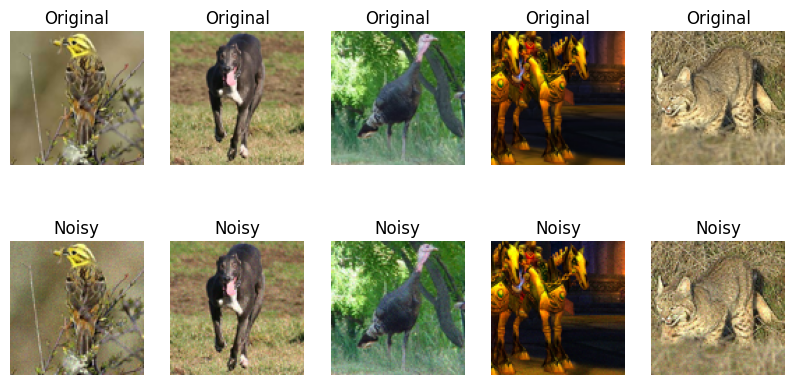

Mean SSIM: 0.9022064208984375


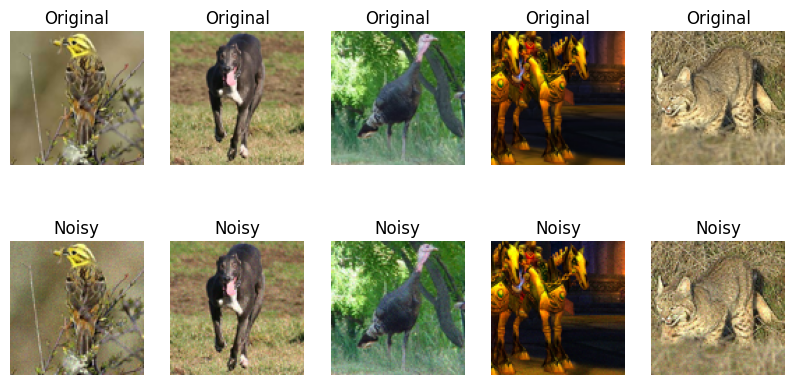

In [7]:
def calculate_psnr_batch(original, noisy,device= 'cuda'):
    original = original.to(device)
    noisy = noisy.to(device)
    batch_size = original.shape[0]
    psnr_values = []
    for i in range(batch_size):
        mse = torch.mean((original[i] - noisy[i]) ** 2).item()
        if mse == 0:
            psnr_values.append(100)
        else:
            max_pixel = 1.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

def calculate_ssim_batch(original, noisy):
    batch_size = original.shape[0]
    ssim_values = []
    for i in range(batch_size):
        ssim_value = ssim(
            original[i].permute(1, 2, 0).numpy(),
            noisy[i].permute(1, 2, 0).numpy(),
            win_size=3,
            channel_axis=2,
            data_range=1.0
        )
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

# Calculate PSNR and SSIM for the test set
psnr_values = calculate_psnr_batch(copyImages[:5], noisy_images_gaussian[:5])
mean_psnr = np.mean(psnr_values)
print(f'Mean PSNR: {mean_psnr}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

ssim_values = calculate_ssim_batch(copyImages[:5], noisy_images_gaussian[:5])


mean_ssim = np.mean(ssim_values)


print(f'Mean SSIM: {mean_ssim}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

In [5]:
# Define model
model = KAN([96*96*3, 256, 512, 512, 512, 1024, 10]) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define Adagrad optimizer
#optimizer = optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define SGD optimizer
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


In [6]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(15):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    trainnoiseerror = 0.0
    with tqdm(train_loader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            #img = images.clone()
            #noisy_images = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2).to(device)
            #trainnoiseerror = calculate_psnr_batch(img,noisy_images,device)
            #print(images[0][:5].shape,noisy_images[0][:5].shape)
            #fig(img[:5],noisy_images[:5],device)
            images = images.view(-1, 96*96*3).to(device)  # Adjusted for 96x96 images
            optimizer.zero_grad()
            features = model(images)
            labels_one_hot = torch.eye(10)[labels].to(device)  # STL-10 has 10 classes
            loss = criterion(features, labels_one_hot)
            #loss = criterion(features, labels)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted_labels = torch.max(features, 1)
            accuracy = (predicted_labels == labels.to(device)).float().mean()
            
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    trainnoiseerror /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    valnoiseerror = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            #img = images.clone()
            #noisy_images = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2).to(device)
            #valnoiseerror = calculate_psnr_batch(img,noisy_images,device)

            images = images.view(-1, 96*96*3).to(device)  # Adjusted for 96x96 images
            output = model(images)
            
            # Assuming labels are already one-hot encoded for multi-label classification
            labels_one_hot = torch.eye(10)[labels].to(device)  # STL-10 has 10 classes
            val_loss += criterion(output, labels_one_hot).item()
            
            # Compute accuracy
            _, predicted_labels = torch.max(output, 1)
            val_accuracy += (predicted_labels == labels.to(device)).float().mean().item()

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    valnoiseerror /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Train Noise Error: {trainnoiseerror}, Val Noise Error: {valnoiseerror}")
    

In [8]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./STL-10_IB_adamW_0.9_BCE.csv", index=False)

Text(0.5, 1.0, 'Accuracy vs. Epochs')

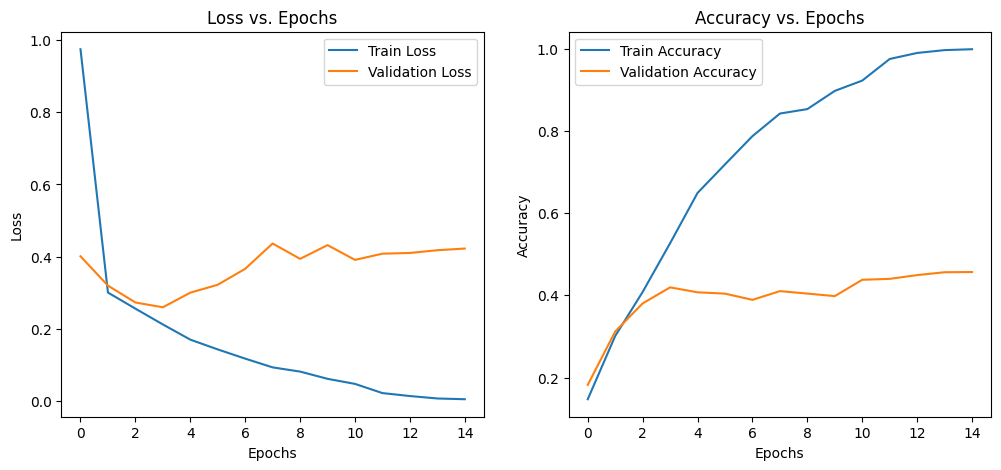

In [9]:
# Plotting
epochs = range(15)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')